In [66]:
import deepsurvk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import sklearn as sk

from sksurv.metrics import (
    concordance_index_ipcw,
    concordance_index_censored,
    brier_score,
    cumulative_dynamic_auc
)
from sklearn.model_selection import KFold

from lifelines.utils import concordance_index

In [67]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout, ActivityRegularization,Activation,BatchNormalization,Input
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import activations
from tensorflow.keras.callbacks import Callback
tf.random.set_seed(108)

In [68]:
n_folds = 5
random_state = 108
from datetime import date

today = date.today()
today_stf = '20241022'

In [69]:
try:
    results = pd.read_csv("results/outcome_{}.csv".format(today_stf),index_col=0)
except:
    results = pd.DataFrame(columns = ["model",
                                      "test_ci","test_ipcw","test_auc","test_brier","n_features"])
print(results)

          model   test_ci  test_ipcw  test_auc  test_brier  n_features
0           cph  0.692135   0.669471  0.698576    0.037291          75
1           cph  0.635765   0.630295  0.635606    0.036934           5
2           cph  0.662431   0.652060  0.658872    0.037187          10
3           cph  0.690876   0.675977  0.692287    0.036998          15
4           cph  0.687534   0.676775  0.686732    0.036937          20
5     ridge_cph  0.688925   0.675802  0.687202    0.036771          75
6     ridge_cph  0.685187   0.676750  0.677265    0.036880          20
7     ridge_cph  0.682904   0.677161  0.675049    0.036841          15
8     ridge_cph  0.681411   0.671781  0.671709    0.037094          10
9     ridge_cph  0.666902   0.664046  0.657276    0.037176           5
10    lasso_cph  0.692884   0.682717  0.688963    0.037021          75
11    lasso_cph  0.692404   0.687822  0.686884    0.036884          20
12    lasso_cph  0.688631   0.679441  0.683937    0.037051          15
13    

In [70]:
def exponential_transformation_gender(row, column,gender_col, bounds, k=1):
    
    if row[gender_col] == 1:
        #male
        lower_bound, upper_bound = bounds["male"][0], bounds["male"][1]
    elif row[gender_col] == 0:
        lower_bound, upper_bound = bounds["female"][0], bounds["female"][1]
    else:
        return np.nan  # Unknown gender handling
    
    value = row[column]
    
    # Apply exponential transformation with scaling factor k
    if lower_bound <= value <= upper_bound:
        return 1  # Optimal range
    elif value < lower_bound:
        return np.exp(k * (lower_bound - value))  # Exponential penalty below range
    else:
        return np.exp(k * (value - upper_bound))  # Exponential penalty above range

def exponential_transformation(row, column, bounds, k=1):
    
    
    lower_bound, upper_bound = bounds[0], bounds[1]
    
    value = row[column]
    
    # Apply exponential transformation with scaling factor k
    if lower_bound <= value <= upper_bound:
        return 1  # Optimal range
    elif value < lower_bound:
        return np.exp(k * (lower_bound - value))  # Exponential penalty below range
    else:
        return np.exp(k * (value - upper_bound))  # Exponential penalty above range


In [71]:
# https://www.seslhd.health.nsw.gov.au/sites/default/files/2019-04/NSWHP%20Reference%20Ranges%20Adult%202019.pdf
train = pd.read_csv("train.csv",index_col = 0)



train['haemoglobin_adj'] = train.apply(exponential_transformation_gender, axis=1, k=2e-2,
                                      column='haemoglobin',gender_col='gender_2.0',
                                     bounds={'male':(130,170),'female':(120,150)})
train['creatinine_adj'] = train.apply(exponential_transformation_gender, axis=1, k=2e-3,
                                      column='creatinine',gender_col='gender_2.0',
                                     bounds={'male':(60,110),'female':(45,90)})
train['albumin_adj'] = train.apply(exponential_transformation, axis=1, k=1e-1,
                                      column='albumin',
                                     bounds=(33,48))
train['platelet_count_adj'] = train.apply(exponential_transformation, axis=1, k=4e-6,
                                      column='platelet_count',
                                     bounds=(150e3,450e3))
#train['inr_adj'] = train.apply(exponential_transformation, axis=1, k=0.5,
#                                      column='inr',
#                                     bounds=(0.8,1.1))

# https://cardiacmri.com/analysis-guide/aortic-valve-2/aortic-stenosis-2/ using mild as upperbound
train['av_peak_vel_adj'] = train.apply(exponential_transformation, axis=1, k=0.5,
                                      column='av_peak_vel',
                                     bounds=(1,3))

# https://cardiacmri.com/analysis-guide/aortic-valve-2/aortic-stenosis-2/ 
train['av_mean_grad_tte_adj'] = train.apply(exponential_transformation, axis=1, k=2e-2,
                                      column='av_mean_grad_tte',
                                     bounds=(0,20))

train['av_area_tte_adj'] = train.apply(exponential_transformation, axis=1, k=1,
                                      column='av_area_tte',
                                     bounds=(2,np.inf))

test = pd.read_csv("test.csv",index_col = 0)
test['haemoglobin_adj'] = test.apply(exponential_transformation_gender, axis=1, k=2e-2,
                                      column='haemoglobin',gender_col='gender_2.0',
                                     bounds={'male':(130,170),'female':(120,150)})
test['creatinine_adj'] = test.apply(exponential_transformation_gender, axis=1, k=2e-3,
                                      column='creatinine',gender_col='gender_2.0',
                                     bounds={'male':(60,110),'female':(45,90)})
test['albumin_adj'] = test.apply(exponential_transformation, axis=1, k=1e-1,
                                      column='albumin',
                                     bounds=(33,48))
test['platelet_count_adj'] = test.apply(exponential_transformation, axis=1, k=4e-6,
                                      column='platelet_count',
                                     bounds=(150e3,450e3))
#test['inr_adj'] = test.apply(exponential_transformation, axis=1, k=0.5,
#                                      column='inr',
#                                     bounds=(0.8,1.1))
test['av_peak_vel_adj'] = test.apply(exponential_transformation, axis=1, k=0.5,
                                      column='av_peak_vel',
                                     bounds=(1,3))
test['av_mean_grad_tte_adj'] = test.apply(exponential_transformation, axis=1, k=2e-2,
                                      column='av_mean_grad_tte',
                                     bounds=(0,20))

test['av_area_tte_adj'] = test.apply(exponential_transformation, axis=1, k=1,
                                      column='av_area_tte',
                                     bounds=(2,np.inf))

In [72]:

#X_train = train.query('death_observed == True or death_in_study == False')
outcome_columns = ['death_in_study','upper_bound',
                       'discharge_status_new','fup_status_30d_new', 'fup_status_12mth_new','lower_bound','death_observed',
                  'event_observed', 'event_max','event_min','event_mid']
X_train = train.drop(outcome_columns,axis=1)
X_train = X_train.drop(["egfr_pre"],axis=1)

In [73]:
categorical_columns_to_keep = [
'gender_2.0', 'cad_1.0', 'prior_acute_mi_1.0', 'prior_cardio_surg_1.0',
       'prior_pci_1.0', 'prior_cabg_1.0', 'prior_valve_replace_1.0',
       'prior_bav_1.0', 'prior_af_1.0', 'prior_generator_1.0', 'prior_ccf_1.0',
       'prior_stroke_1.0', 'prior_tia_1.0', 'prior_carotid_sten_2.0',
       'prior_carotid_sten_3.0', 'prior_carotid_sten_4.0',
       'prior_carotid_sten_5.0', 'prior_pad_1.0', 'chronic_lung_2.0',
       'chronic_lung_3.0', 'chronic_lung_4.0', 'hypertension_1.0',
       'diabetes_1.0', 'ckd_1.0', 'dialysis_1.0', 'meds_ACE_ARB_1.0',
       'meds_aspirin_1.0', 'meds_p2y12_1.0', 'meds_beta_blocker_1.0',
       'meds_doac_1.0', 'meds_statins_1.0', 'meds_diuretics_1.0',
       'nyha_status_3.0', 
    'ecg_rhythm_sinus_1.0',
       'ecg_rhythm_Fibrillation_1.0', 'ecg_rhythm_paced_1.0',
       'ecg_conduct_none_1.0', 'ecg_conduct_RBBB_1.0', 'ecg_conduct_LBBB_1.0',
       'ecg_conduct_1DAVBlock_1.0', 
    'diseased_vessels_number_2.0',
       'diseased_vessels_number_3.0', 'diseased_vessels_number_4.0',
       'prox_lad_1.0', 'aortic_insuff_2.0', 'aortic_insuff_3.0',
       'aortic_insuff_4.0', 'mitral_regurg_1.0', 'av_disease_etiology_2.0',
       'valve_calc_1.0', 'annualar_calc_ctaort_1.0', 'valve_morph_1.0',
       'artery_calc_2.0', 'artery_calc_3.0',
    'artery_calc_4.0',
       'iliofem_tort_2.0', 'iliofem_tort_3.0', 'iliofem_tort_4.0',
       'high_cfa_burif_1.0', 
    #'prev_iliofem_interv_1.0', 
    'procedure_indic_1.0',
       #'valve_in_valve_1.0', 
    'anaesthesia_2.0', 'anaesthesia_4.0',
       'initial_bav_1.0'
    ] 
    #'device_manufacturer_1_2.0',
       #'device_manufacturer_1_3.0',
        #'lvef_value_scale_2.0',
#'lvef_value_scale_3.0',
#'lvef_value_scale_4.0']
cont_columns_to_keep = [
    #'haemoglobin',
    'haemoglobin_adj',
    #'platelet_count',
    'platelet_count_adj',
    #'albumin',
    'albumin_adj',
    'creatinine',
    #'creatinine_adj',
    'lvef_value',
    'av_peak_vel',	
    #'av_peak_vel_adj',
    'av_mean_grad_tte',	
    #'av_mean_grad_tte_adj',
    'av_area_tte',	
    #'av_area_tte_adj',
    'weight',
    'age',
    'kccq_summ_bl',
]
#X_train = X_train[categorical_columns_to_keep + cont_columns_to_keep]

In [74]:
X_train = X_train[list(categorical_columns_to_keep) + cont_columns_to_keep]

In [75]:

y = train[["death_in_study","event_max" ]]

records = y.to_records(index=False)
y_train = np.array(records, dtype = records.dtype.descr)


X_test = test.drop(outcome_columns,axis=1)
X_test = X_test.drop(["egfr_pre"],axis=1)
X_test = X_test[list(categorical_columns_to_keep) + cont_columns_to_keep]
#X_test = X_test.loc[:,column_list]
#X_test_scale = scaler.transform(X_test)
#X_test_scale = pd.DataFrame(X_test_scale,columns=X_test.columns,index=test.index)

y_test = test[["death_in_study","event_max" ]]

records = y_test.to_records(index=False)
y_test = np.array(records, dtype = records.dtype.descr)

In [76]:
from lifelines import KaplanMeierFitter
# Create a censoring indicator (1 = censored, 0 = event)
data = pd.concat([X_train,y],axis=1)


data['censoring_indicator'] = 1 - data['death_in_study']

# Fit the Kaplan-Meier model to censoring data
kmf_censor = KaplanMeierFitter()

# Fit the model where time is the follow-up time and censoring_indicator denotes censoring
kmf_censor.fit(durations=data['event_max'], event_observed=data['censoring_indicator'])

# Predict the survival probability of being uncensored (censoring probability)
data['S_c'] = kmf_censor.survival_function_at_times(data['event_max']).values
data['ipcw'] = 1 / (data['S_c']+1e-3)

In [77]:
from lifelines import CoxPHFitter

# Define a Cox model for censoring (using covariates if available)
censoring_model = CoxPHFitter()
censoring_data = data.drop(['death_in_study','S_c','ipcw','death_in_study'],axis=1)
censoring_model.fit(censoring_data, duration_col='event_max', event_col='censoring_indicator')

censoring_model.print_summary()
# Predict censoring probabilities
data['S_cox'] = censoring_model.predict_survival_function(censoring_data).iloc[-1]
data['ipcw_cox'] = 1 / (data['S_cox'] + 1e-3)

<lifelines.CoxPHFitter: fitted with 12898 total observations, 697 right-censored observations>
             duration col = 'event_max'
                event col = 'censoring_indicator'
      baseline estimation = breslow
   number of observations = 12898
number of events observed = 12201
   partial log-likelihood = -102971.95
         time fit was run = 2024-11-06 09:29:41 UTC

---
                              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                           
gender_2.0                    0.00       1.00       0.02            -0.04             0.05                 0.96                 1.05
cad_1.0                       0.04       1.05       0.02             0.00             0.09                 1.00                 1.09
prior_acute_mi_1.0           -0.03       0.97       0.03            -0.08             0.03                 0.92                 1.03
prior_cardio_surg_1.0        -0.07       0.93       0.05            -0.17             0.03                 0.84                 1.03
prior_pci_1.0                -0.02       0.98       0.02            -0.07             0.03                 0.94                 1.03
prior_cabg_1.0               -0.05       0.95       0.05            -0.15             0.06                 0.86                 1.06
prior_valve_replace_1.0      -0.12       0.89       0.07            -0.26             0.02                 0.77                 1.02
prior_bav_1.0                -0.24       0.78       0.04            -0.32            -0.16                 0.72                 0.85
prior_af_1.0                 -0.07       0.93       0.03            -0.13            -0.02                 0.88                 0.98
prior_generator_1.0          -0.05       0.95       0.04            -0.13             0.03                 0.88                 1.03
prior_ccf_1.0                -0.08       0.92       0.02            -0.13            -0.04                 0.88                 0.96
prior_stroke_1.0             -0.02       0.98       0.04            -0.09             0.05                 0.92                 1.05
prior_tia_1.0                -0.06       0.94       0.04            -0.13             0.01                 0.88                 1.01
prior_carotid_sten_2.0        0.05       1.05       0.07            -0.08             0.19                 0.92                 1.20
prior_carotid_sten_3.0       -0.02       0.98       0.07            -0.15             0.11                 0.86                 1.11
prior_carotid_sten_4.0       -0.13       0.87       0.04            -0.21            -0.06                 0.81                 0.95
prior_carotid_sten_5.0       -0.04       0.96       0.02            -0.08            -0.00                 0.92                 1.00
prior_pad_1.0                -0.00       1.00       0.03            -0.06             0.05                 0.94                 1.05
chronic_lung_2.0             -0.04       0.96       0.02            -0.09             0.01                 0.92                 1.01
chronic_lung_3.0             -0.03       0.97       0.03            -0.09             0.03                 0.91                 1.04
chronic_lung_4.0             -0.16       0.85       0.05            -0.26            -0.06                 0.77                 0.94
hypertension_1.0              0.01       1.01       0.02            -0.03             0.06                 0.97                 1.06
diabetes_1.0                 -0.05       0.96       0.02            -0.09            -0.00                 0.92                 1.00
ckd_1.0                      -0.03       0.97       0.02            -0.08             0.01                 0.93                 1.01
dialysis_1.0                 -0.17       0.85       0.09            -0.35             0.02                 0.70                 1.02
meds_ACE_ARB_1.0        

<Axes: xlabel='S_cox', ylabel='Density'>

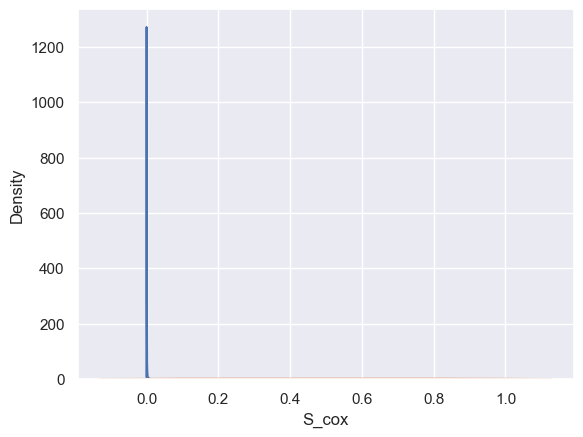

In [78]:
sns.kdeplot(data['S_cox'])
sns.kdeplot(data['S_c'])

In [79]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                            classes = np.unique(y_train['death_in_study']),
                                            y = y_train['death_in_study'])
class_weights_dict = dict(zip(np.unique(y_train['death_in_study']).astype(int), class_weights))

In [80]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler


X_scaler = StandardScaler().fit(X_train)
X_train_scale = X_scaler.transform(X_train)

Y_scaler = StandardScaler().fit(y_train["event_max"].reshape(-1, 1))
y_train_scale = Y_scaler.transform(y_train["event_max"].reshape(-1, 1))
y_train_scale = y_train_scale.flatten()
#y_train_scale = y_train["event_max"].flatten()

y_test_scale = Y_scaler.transform(y_test["event_max"].reshape(-1, 1))
y_test_scale = y_test_scale.flatten()
#y_test_scale = y_test["event_max"].flatten()

In [81]:
sort_idx = np.argsort(y_train["event_max"], axis=0)[::-1]
X_train_scale = X_train_scale[sort_idx, :]
y_train_scale = y_train_scale[sort_idx]
y_train_sort = y_train["event_max"][sort_idx].reshape(-1, 1)
E_train = y_train["death_in_study"][sort_idx]
y_train_record_sort = y_train[sort_idx]

ipcw_weights = np.array(data["ipcw"])[sort_idx]
death_train = y_train["death_in_study"][sort_idx].astype(float)

In [82]:
n_features = X_train.shape[1]
n_batch = X_train.shape[0]

In [83]:
# Custom scaled tanh activation function
def scaled_tanh(x):
    return 7 * tf.tanh(x)  # Scale tanh output to range [-10, 10]

In [84]:
def negative_log_likelihood(E):
    def loss(y_true, y_pred):
        
        hazard_ratio = tf.math.exp(y_pred)        
        log_risk = tf.math.log(tf.math.cumsum(hazard_ratio))
        uncensored_likelihood = tf.transpose(y_pred) - log_risk
        censored_likelihood =  uncensored_likelihood * E
        neg_likelihood_ = -tf.math.reduce_sum(censored_likelihood)

        # TODO
        # For some reason, adding num_observed_events does not work.
        # Therefore, for now we will use it as a simple factor of 1.
        # Is it really needed? Isn't it just a scaling factor?
        # num_observed_events = tf.math.cumsum(E)
        # num_observed_events = tf.cast(num_observed_events, dtype=tf.float32)
        #num_observed_events = tf.constant(1, dtype=tf.float32)
        num_observed_events = tf.math.reduce_sum(E)
        #weight_sum = tf.math.reduce_sum(weights)
        
        neg_likelihood = neg_likelihood_ / (num_observed_events)
        
        #output_reg = tf.math.reduce_mean(tf.math.square(y_pred))  # Penalize large output magnitudes
        #reg_weight = 1000
        penalty_threshold = -3
        penalty = tf.math.reduce_mean(tf.math.square(tf.math.maximum(penalty_threshold - y_pred , 0.0)))
        penalty_weight = 10  # Adjust weight
        
         # Define the desired range for the output
        #min_val = -.0  # minimum acceptable value
        #max_val = 5.0   # maximum acceptable value

        # Penalty for predictions outside the range (either too low or too high)
        #lower_penalty = tf.math.maximum(min_val - y_pred, 0.0)  # penalty for being below min_val
        #upper_penalty = tf.math.maximum(y_pred - max_val, 0.0)  # penalty for being above max_val

        # Combine penalties
        #penalty = tf.math.reduce_mean(tf.math.square(lower_penalty) + tf.math.square(upper_penalty))

        # Apply a scaling factor to the penalty to adjust its impact
        #penalty_weight = 0.01  # Adjust this to control the strength of the penalty
        total_loss = neg_likelihood + penalty_weight * penalty
        
        
        
        return neg_likelihood
    
    return loss

In [85]:
def weighted_binary_crossentropy(class_weights):
    def loss(y_true, y_pred):
        b_ce = tf.keras.losses.binary_crossentropy(y_true, y_pred)

        # Apply the weights
        weight_vector = y_true * class_weights[1] + (1. - y_true) * class_weights[0]
        weighted_b_ce = weight_vector * b_ce

        # Return the mean error
        return tf.math.reduce_mean(weighted_b_ce)
    
    return loss

In [86]:
class SelectiveProgbarLogger(tf.keras.callbacks.ProgbarLogger):
    def __init__(self, verbose, epoch_interval, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.default_verbose = verbose
        self.epoch_interval = epoch_interval
    
    def on_epoch_begin(self, epoch, *args, **kwargs):
        self.verbose = (
            0 
                if epoch % self.epoch_interval != 0 
                else self.default_verbose
        )
        super().on_epoch_begin(epoch, *args, **kwargs)

In [87]:
callbacks = [tf.keras.callbacks.TerminateOnNaN(),
            tf.keras.callbacks.EarlyStopping(monitor='loss',patience=20,start_from_epoch=40,verbose=1),
            SelectiveProgbarLogger(verbose = 1,epoch_interval=10)]
             #tf.keras.callbacks.TensorBoard('./logs', update_freq=1)
             # Instantiate the callback with the model
               #GradientMonitor(model, log_frequency=10)]
             #tf.keras.callbacks.ModelCheckpoint(str(PATH_MODELS/f'{example_file}.h5'), monitor='loss', save_best_only=True, mode='min')]

In [88]:
activation = 'relu'
n_nodes = 96
learning_rate = 0.001
l2_reg = 20
dropout = 0.3
lr_decay =  6.494e-3
momentum = 0.2
output_bias_init = np.log(sum(death_train)/(len(death_train) - sum(death_train)))

In [89]:
from itertools import product

param_dict = {
"n_nodes": [24, 48,96],
"learning_rate": [1e-3,1e-2,1e-1],
"dropout": [0.1, 0.2,0.3],
"l2_reg": [1e-1,1,1e1,1e2],
}

product_values = product(*[v if isinstance(v, (list, tuple)) else [v] for v in param_dict.values()])
param_comb = [dict(zip(param_dict.keys(), values)) for values in product_values]

In [90]:
cv = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
cv_score_df = pd.DataFrame(columns=["nodes","learning_rate","dropout","l2_reg",
                                 "ipcw_mean","ipcw_std","ci_mean","ci_std"])
for ele in param_comb:
    n_nodes = ele["n_nodes"]
    dropout = ele["dropout"]
    learning_rate = ele["learning_rate"]
    l2_reg = ele["l2_reg"]
    print("Selecting for")
    print(ele)
    val_score_ipcw = []
    val_score_ci = []
    for train_fold,  val_fold in cv.split(X_train_scale, y_train_scale):


        # Create model
        model = Sequential()

        model.add(Dense(units=n_features, activation=activation, kernel_initializer='glorot_uniform', input_shape=(n_features,)))
        model.add(Dropout(dropout))
        model.add(Dense(units=n_nodes, activation=activation, kernel_initializer='glorot_uniform', kernel_regularizer=l2(l2_reg)))
        model.add(Dropout(dropout))
        model.add(Dense(units=n_nodes, activation=activation, kernel_initializer='glorot_uniform',kernel_regularizer=l2(l2_reg)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
        model.add(Dense(units=1, kernel_initializer='glorot_uniform', kernel_regularizer=l2(l2_reg),activation='linear'
                       ))
        #model.add(Activation(activations.selu))
        model.add(ActivityRegularization(l2=l2_reg))
        #lambda x: activations.selu(x,alpha=0.2))

        # Define the optimizer
        # Nadam is Adam + Nesterov momentum
        # optimizer = Nadam(learning_rate=learning_rate, decay=lr_decay, clipnorm=1) 
        optimizer = Nadam(learning_rate=learning_rate, weight_decay=lr_decay)

        # Compile the model and show a summary of it
        model.compile(loss=negative_log_likelihood(np.float32(E_train[train_fold])), optimizer=optimizer)
        #model.summary()

        epochs = 500

        history = model.fit(X_train_scale[train_fold], y_train_scale[train_fold],
                        batch_size=len(train_fold), 
                        epochs=epochs, 
                        callbacks=callbacks,
                        shuffle=False,
                           verbose=0)

        val_prediction = np.exp(-model.predict(X_train_scale[val_fold]))
        c_uno = concordance_index_ipcw(
            y_train_record_sort[train_fold], 
            y_train_record_sort[val_fold], 
            val_prediction.reshape((-1,)),
            tau=365)
        c_harrell = concordance_index_censored(E_train[val_fold], y_train_scale[val_fold], val_prediction.reshape((-1,)))
        val_score_ipcw.append(c_uno[0])
        val_score_ci.append(c_harrell[0])
    val_dict = ele
    val_dict["ipcw_mean"] = np.mean(np.array(val_score_ipcw))
    val_dict["ipcw_std"] = np.std(np.array(val_score_ipcw))
                                
    val_dict["ci_mean"] = np.mean(np.array(val_score_ci))
    val_dict["ci_std"] = np.std(np.array(val_score_ci))
                                
    cv_score_df = pd.concat([cv_score_df,pd.DataFrame([val_dict])],axis=0,ignore_index=True)
    cv_score_df.to_csv("results/deepsurv_results_{}.csv".format(today_stf))
    print(cv_score_df)

Selecting for
{'n_nodes': 24, 'learning_rate': 0.001, 'dropout': 0.1, 'l2_reg': 0.1}
Epoch 1/500
1/1 [==============================] - 2s 2s/sample - loss: 100834.3672
Epoch 11/500
1/1 [==============================] - 0s 242ms/sample - loss: 92744.0156
Epoch 21/500
1/1 [==============================] - 0s 230ms/sample - loss: 89557.1875
Epoch 31/500
1/1 [==============================] - 0s 240ms/sample - loss: 87631.4844
Epoch 41/500
1/1 [==============================] - 0s 238ms/sample - loss: 86354.5391
Epoch 51/500
1/1 [==============================] - 0s 270ms/sample - loss: 85351.5625
Epoch 61/500
1/1 [==============================] - 0s 260ms/sample - loss: 84323.5391
Epoch 71/500
1/1 [==============================] - 0s 259ms/sample - loss: 84137.0312
Epoch 81/500
1/1 [==============================] - 0s 252ms/sample - loss: 83155.2578
Epoch 91/500
1/1 [==============================] - 0s 263ms/sample - loss: 82472.1406
Epoch 101/500
1/1 [=============================

1/1 [==============================] - 0s 232ms/sample - loss: 73336.7031
Epoch 421/500
1/1 [==============================] - 0s 236ms/sample - loss: 72497.6016
Epoch 431/500
1/1 [==============================] - 0s 240ms/sample - loss: 72946.6094
Epoch 441/500
1/1 [==============================] - 0s 234ms/sample - loss: 72257.9766
Epoch 451/500
1/1 [==============================] - 0s 236ms/sample - loss: 71495.7500
Epoch 461/500
1/1 [==============================] - 0s 238ms/sample - loss: 72073.5781
Epoch 471/500
1/1 [==============================] - 0s 235ms/sample - loss: 71657.1328
Epoch 481/500
1/1 [==============================] - 0s 239ms/sample - loss: 70687.4453
Epoch 491/500
81/81 [==============================] - 0s 757us/step
Epoch 1/500
1/1 [==============================] - 2s 2s/sample - loss: 105191.8438
Epoch 11/500
1/1 [==============================] - 0s 236ms/sample - loss: 106548.7500
Epoch 21/500
1/1 [==============================] - 0s 237ms/sample -

1/1 [==============================] - 0s 227ms/sample - loss: 82049.7266
Epoch 91/500
1/1 [==============================] - 0s 227ms/sample - loss: 82081.5703
Epoch 101/500
1/1 [==============================] - 0s 228ms/sample - loss: 80888.1484
Epoch 111/500
1/1 [==============================] - 0s 222ms/sample - loss: 80695.2656
Epoch 121/500
1/1 [==============================] - 0s 224ms/sample - loss: 80275.2891
Epoch 131/500
1/1 [==============================] - 0s 225ms/sample - loss: 79588.5781
Epoch 141/500
1/1 [==============================] - 0s 225ms/sample - loss: 79098.6641
Epoch 151/500
1/1 [==============================] - 0s 225ms/sample - loss: 78870.2266
Epoch 161/500
1/1 [==============================] - 0s 227ms/sample - loss: 78473.1719
Epoch 171/500
1/1 [==============================] - 0s 227ms/sample - loss: 77730.8203
Epoch 181/500
1/1 [==============================] - 0s 222ms/sample - loss: 115752.3125
Epoch 191/500
1/1 [===========================

1/1 [==============================] - 0s 212ms/sample - loss: 81759.0781
Epoch 231/500
1/1 [==============================] - 0s 211ms/sample - loss: 81349.0000
Epoch 235: early stopping
81/81 [==============================] - 0s 728us/step
Epoch 1/500
1/1 [==============================] - 2s 2s/sample - loss: 123074.6875
Epoch 11/500
1/1 [==============================] - 0s 212ms/sample - loss: 101734.2500
Epoch 21/500
1/1 [==============================] - 0s 200ms/sample - loss: 98730.2578
Epoch 31/500
1/1 [==============================] - 0s 208ms/sample - loss: 94856.3047
Epoch 41/500
1/1 [==============================] - 0s 208ms/sample - loss: 116232.1484
Epoch 51/500
1/1 [==============================] - 0s 205ms/sample - loss: 90736.9609
Epoch 61/500
1/1 [==============================] - 0s 209ms/sample - loss: 90589.1641
Epoch 71/500
1/1 [==============================] - 0s 207ms/sample - loss: 89598.8906
Epoch 81/500
1/1 [==============================] - 0s 208ms/s

1/1 [==============================] - 0s 192ms/sample - loss: 80234.2500
Epoch 171/500
1/1 [==============================] - 0s 196ms/sample - loss: 79812.7266
Epoch 181/500
1/1 [==============================] - 0s 194ms/sample - loss: 79421.6016
Epoch 191/500
1/1 [==============================] - 0s 196ms/sample - loss: 78754.8203
Epoch 201/500
1/1 [==============================] - 0s 198ms/sample - loss: 78871.7109
Epoch 211/500
1/1 [==============================] - 0s 192ms/sample - loss: 78036.2891
Epoch 221/500
1/1 [==============================] - 0s 194ms/sample - loss: 77713.5000
Epoch 231/500
1/1 [==============================] - 0s 195ms/sample - loss: 77194.0469
Epoch 241/500
1/1 [==============================] - 0s 195ms/sample - loss: 76520.6406
Epoch 251/500
1/1 [==============================] - 0s 190ms/sample - loss: 75879.9609
Epoch 261/500
1/1 [==============================] - 0s 193ms/sample - loss: 75245.8750
Epoch 271/500
1/1 [===========================

Epoch 91/500
1/1 [==============================] - 0s 181ms/sample - loss: 84639.8438
Epoch 101/500
1/1 [==============================] - 0s 190ms/sample - loss: 84531.1328
Epoch 111/500
1/1 [==============================] - 0s 185ms/sample - loss: 84575.2969
Epoch 121/500
1/1 [==============================] - 0s 182ms/sample - loss: 84176.7266
Epoch 131/500
1/1 [==============================] - 0s 183ms/sample - loss: 83922.1172
Epoch 141/500
1/1 [==============================] - 0s 184ms/sample - loss: 83709.5312
Epoch 151/500
1/1 [==============================] - 0s 190ms/sample - loss: 83535.7031
Epoch 161/500
1/1 [==============================] - 0s 190ms/sample - loss: 83800.7578
Epoch 171/500
1/1 [==============================] - 0s 210ms/sample - loss: 82483.5156
Epoch 181/500
1/1 [==============================] - 0s 197ms/sample - loss: 82543.0547
Epoch 191/500
1/1 [==============================] - 0s 193ms/sample - loss: 82573.4219
Epoch 201/500
1/1 [==============

1/1 [==============================] - 0s 186ms/sample - loss: 72729.9062
Epoch 291/500
1/1 [==============================] - 0s 179ms/sample - loss: 72525.7578
Epoch 301/500
1/1 [==============================] - 0s 182ms/sample - loss: 71749.5703
Epoch 311/500
1/1 [==============================] - 0s 176ms/sample - loss: 71956.9688
Epoch 321/500
1/1 [==============================] - 0s 184ms/sample - loss: 71240.5156
Epoch 331/500
1/1 [==============================] - 0s 183ms/sample - loss: 69558.5703
Epoch 341/500
1/1 [==============================] - 0s 199ms/sample - loss: 69670.8281
Epoch 351/500
1/1 [==============================] - 0s 196ms/sample - loss: 69795.6172
Epoch 361/500
1/1 [==============================] - 0s 186ms/sample - loss: 68851.1641
Epoch 371/500
1/1 [==============================] - 0s 197ms/sample - loss: 68145.6172
Epoch 381/500
1/1 [==============================] - 0s 192ms/sample - loss: 68271.8906
Epoch 391/500
1/1 [===========================

1/1 [==============================] - 0s 200ms/sample - loss: 88063.7188
Epoch 151/500
1/1 [==============================] - 0s 198ms/sample - loss: 87371.7578
Epoch 161/500
1/1 [==============================] - 0s 182ms/sample - loss: 87091.1562
Epoch 171/500
1/1 [==============================] - 0s 197ms/sample - loss: 87171.7656
Epoch 181/500
1/1 [==============================] - 0s 194ms/sample - loss: 85735.7344
Epoch 191/500
1/1 [==============================] - 0s 195ms/sample - loss: 85696.0156
Epoch 201/500
1/1 [==============================] - 0s 190ms/sample - loss: 85674.3906
Epoch 211/500
1/1 [==============================] - 0s 194ms/sample - loss: 84838.8281
Epoch 221/500
1/1 [==============================] - 0s 192ms/sample - loss: 84151.2578
Epoch 231/500
1/1 [==============================] - 0s 181ms/sample - loss: 84200.1016
Epoch 241/500
1/1 [==============================] - 0s 179ms/sample - loss: 83905.6797
Epoch 251/500
1/1 [===========================

1/1 [==============================] - 0s 178ms/sample - loss: 96219.9688
Epoch 71/500
1/1 [==============================] - 0s 200ms/sample - loss: 95000.5547
Epoch 81/500
1/1 [==============================] - 0s 200ms/sample - loss: 94724.3750
Epoch 91/500
1/1 [==============================] - 0s 178ms/sample - loss: 93629.3438
Epoch 101/500
1/1 [==============================] - 0s 178ms/sample - loss: 93239.8516
Epoch 111/500
1/1 [==============================] - 0s 175ms/sample - loss: 92289.2031
Epoch 121/500
1/1 [==============================] - 0s 176ms/sample - loss: 91416.2344
Epoch 131/500
1/1 [==============================] - 0s 174ms/sample - loss: 91072.8906
Epoch 141/500
1/1 [==============================] - 0s 211ms/sample - loss: 90716.2344
Epoch 151/500
1/1 [==============================] - 0s 182ms/sample - loss: 90389.5547
Epoch 161/500
1/1 [==============================] - 0s 177ms/sample - loss: 90073.7578
Epoch 171/500
1/1 [==============================

1/1 [==============================] - 0s 176ms/sample - loss: 87496.1875
Epoch 111/500
1/1 [==============================] - 0s 194ms/sample - loss: 87319.7656
Epoch 121/500
1/1 [==============================] - 0s 177ms/sample - loss: 86711.3281
Epoch 131/500
1/1 [==============================] - 0s 197ms/sample - loss: 86445.7422
Epoch 141/500
1/1 [==============================] - 0s 178ms/sample - loss: 86638.8438
Epoch 151/500
1/1 [==============================] - 0s 173ms/sample - loss: 85867.0078
Epoch 161/500
1/1 [==============================] - 0s 179ms/sample - loss: 85547.9219
Epoch 171/500
1/1 [==============================] - 0s 177ms/sample - loss: 85293.8047
Epoch 181/500
1/1 [==============================] - 0s 204ms/sample - loss: 85199.3672
Epoch 191/500
1/1 [==============================] - 0s 170ms/sample - loss: 84605.8828
Epoch 201/500
1/1 [==============================] - 0s 198ms/sample - loss: 84912.8438
Epoch 211/500
1/1 [===========================

1/1 [==============================] - 0s 177ms/sample - loss: 91454.4453
Epoch 61/500
1/1 [==============================] - 0s 180ms/sample - loss: 89277.0781
Epoch 71/500
1/1 [==============================] - 0s 173ms/sample - loss: 88495.6562
Epoch 81/500
1/1 [==============================] - 0s 194ms/sample - loss: 89024.5000
Epoch 91/500
1/1 [==============================] - 0s 172ms/sample - loss: 87688.7344
Epoch 101/500
1/1 [==============================] - 0s 195ms/sample - loss: 87060.5938
Epoch 111/500
1/1 [==============================] - 0s 195ms/sample - loss: 86321.3125
Epoch 121/500
1/1 [==============================] - 0s 202ms/sample - loss: 86334.7656
Epoch 131/500
1/1 [==============================] - 0s 198ms/sample - loss: 85842.6094
Epoch 141/500
1/1 [==============================] - 0s 208ms/sample - loss: 86927.8672
Epoch 151/500
1/1 [==============================] - 0s 182ms/sample - loss: 84975.5547
Epoch 161/500
1/1 [==============================]

1/1 [==============================] - 0s 196ms/sample - loss: 83531.4453
Epoch 101/500
1/1 [==============================] - 0s 198ms/sample - loss: 81601.3984
Epoch 111/500
1/1 [==============================] - 0s 202ms/sample - loss: 81633.1484
Epoch 121/500
1/1 [==============================] - 0s 204ms/sample - loss: 82146.7734
Epoch 121: early stopping
81/81 [==============================] - 0s 1000us/step
Epoch 1/500
1/1 [==============================] - 2s 2s/sample - loss: 250378.2969
Epoch 11/500
1/1 [==============================] - 0s 179ms/sample - loss: 136077.6406
Epoch 21/500
1/1 [==============================] - 0s 198ms/sample - loss: 148382.3906
Epoch 31/500
1/1 [==============================] - 0s 203ms/sample - loss: 122746.0938
Epoch 41/500
1/1 [==============================] - 0s 185ms/sample - loss: 109778.7031
Epoch 51/500
1/1 [==============================] - 0s 188ms/sample - loss: 109505.9375
Epoch 61/500
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 197ms/sample - loss: 88556.5234
Epoch 91/500
1/1 [==============================] - 0s 200ms/sample - loss: 87314.6406
Epoch 101/500
1/1 [==============================] - 0s 199ms/sample - loss: 87778.6875
Epoch 111/500
1/1 [==============================] - 0s 192ms/sample - loss: 86599.3438
Epoch 121/500
1/1 [==============================] - 0s 200ms/sample - loss: 86372.5938
Epoch 130: early stopping
81/81 [==============================] - 0s 705us/step
Epoch 1/500
1/1 [==============================] - 2s 2s/sample - loss: 115683.4141
Epoch 11/500
1/1 [==============================] - 0s 191ms/sample - loss: 101522.9922
Epoch 21/500
1/1 [==============================] - 0s 177ms/sample - loss: 98190.3047
Epoch 31/500
1/1 [==============================] - 0s 197ms/sample - loss: 96161.0234
Epoch 41/500
1/1 [==============================] - 0s 202ms/sample - loss: 93292.9922
Epoch 51/500
1/1 [==============================] - 0s 191ms/

Epoch 1/500
1/1 [==============================] - 2s 2s/sample - loss: 117203.4297
Epoch 11/500
1/1 [==============================] - 0s 189ms/sample - loss: 109302.1484
Epoch 21/500
1/1 [==============================] - 0s 185ms/sample - loss: 102168.0000
Epoch 31/500
1/1 [==============================] - 0s 183ms/sample - loss: 98665.8672
Epoch 41/500
1/1 [==============================] - 0s 193ms/sample - loss: 96982.2656
Epoch 51/500
1/1 [==============================] - 0s 187ms/sample - loss: 96175.7031
Epoch 61/500
1/1 [==============================] - 0s 203ms/sample - loss: 95362.9531
Epoch 71/500
1/1 [==============================] - 0s 186ms/sample - loss: 93571.8984
Epoch 81/500
1/1 [==============================] - 0s 187ms/sample - loss: 93578.2344
Epoch 91/500
1/1 [==============================] - 0s 192ms/sample - loss: 92379.8594
Epoch 101/500
1/1 [==============================] - 0s 196ms/sample - loss: 92564.6484
Epoch 111/500
1/1 [========================

Epoch 1/500
1/1 [==============================] - 2s 2s/sample - loss: 126463.6641
Epoch 11/500
1/1 [==============================] - 0s 182ms/sample - loss: 108638.3281
Epoch 21/500
1/1 [==============================] - 0s 183ms/sample - loss: 101660.9219
Epoch 31/500
1/1 [==============================] - 0s 201ms/sample - loss: 95378.5469
Epoch 41/500
1/1 [==============================] - 0s 189ms/sample - loss: 94335.3281
Epoch 51/500
1/1 [==============================] - 0s 203ms/sample - loss: 92398.5391
Epoch 61/500
1/1 [==============================] - 0s 180ms/sample - loss: 91200.1172
Epoch 71/500
1/1 [==============================] - 0s 178ms/sample - loss: 90464.3672
Epoch 81/500
1/1 [==============================] - 0s 178ms/sample - loss: 90372.8594
Epoch 91/500
1/1 [==============================] - 0s 182ms/sample - loss: 90134.1172
Epoch 101/500
1/1 [==============================] - 0s 186ms/sample - loss: 90540.1406
Epoch 111/500
1/1 [========================

Epoch 1/500
1/1 [==============================] - 2s 2s/sample - loss: 102718.3750
Epoch 11/500
1/1 [==============================] - 0s 180ms/sample - loss: 98089.2266
Epoch 21/500
1/1 [==============================] - 0s 191ms/sample - loss: 93930.6406
Epoch 31/500
1/1 [==============================] - 0s 193ms/sample - loss: 91684.7656
Epoch 41/500
1/1 [==============================] - 0s 185ms/sample - loss: 90494.9219
Epoch 51/500
1/1 [==============================] - 0s 182ms/sample - loss: 89511.9922
Epoch 61/500
1/1 [==============================] - 0s 189ms/sample - loss: 88760.0234
Epoch 71/500
1/1 [==============================] - 0s 182ms/sample - loss: 88329.7656
Epoch 81/500
1/1 [==============================] - 0s 190ms/sample - loss: 87492.8281
Epoch 91/500
1/1 [==============================] - 0s 189ms/sample - loss: 87407.2031
Epoch 101/500
1/1 [==============================] - 0s 180ms/sample - loss: 87719.4375
Epoch 111/500
1/1 [==========================

Epoch 1/500
1/1 [==============================] - 2s 2s/sample - loss: 132249.9531
Epoch 11/500
1/1 [==============================] - 0s 189ms/sample - loss: 102024.6875
Epoch 21/500
1/1 [==============================] - 0s 188ms/sample - loss: 102459.1094
Epoch 31/500
1/1 [==============================] - 0s 182ms/sample - loss: 99463.9766
Epoch 41/500
1/1 [==============================] - 0s 202ms/sample - loss: 95148.4062
Epoch 51/500
1/1 [==============================] - 0s 203ms/sample - loss: 94153.4531
Epoch 61/500
1/1 [==============================] - 0s 191ms/sample - loss: 95359.4297
Epoch 71/500
1/1 [==============================] - 0s 190ms/sample - loss: 93373.6953
Epoch 81/500
1/1 [==============================] - 0s 189ms/sample - loss: 92363.4766
Epoch 91/500
1/1 [==============================] - 0s 197ms/sample - loss: 90630.8984
Epoch 101/500
1/1 [==============================] - 0s 207ms/sample - loss: 91529.8672
Epoch 111/500
1/1 [========================

Epoch 81/500
1/1 [==============================] - 0s 193ms/sample - loss: 91357.3594
Epoch 91/500
1/1 [==============================] - 0s 187ms/sample - loss: 90292.0625
Epoch 101/500
1/1 [==============================] - 0s 190ms/sample - loss: 89722.9453
Epoch 111/500
1/1 [==============================] - 0s 184ms/sample - loss: 87930.5391
Epoch 121/500
1/1 [==============================] - 0s 186ms/sample - loss: 89697.9375
Epoch 131/500
1/1 [==============================] - 0s 196ms/sample - loss: 89917.4062
Epoch 131: early stopping
81/81 [==============================] - 0s 693us/step
   nodes  learning_rate  dropout  l2_reg  ipcw_mean  ipcw_std   ci_mean  \
0    NaN          0.001      0.1     0.1   0.352392  0.008294  0.367235   
1    NaN          0.001      0.1     1.0   0.343001  0.018912  0.355909   
2    NaN          0.001      0.1    10.0   0.368659  0.023160  0.383987   
3    NaN          0.001      0.1   100.0   0.374270  0.025780  0.388640   
4    NaN          

1/1 [==============================] - 0s 195ms/sample - loss: 95375.1250
Epoch 181/500
1/1 [==============================] - 0s 193ms/sample - loss: 94610.3125
Epoch 191/500
1/1 [==============================] - 0s 197ms/sample - loss: 95520.2578
Epoch 201/500
1/1 [==============================] - 0s 194ms/sample - loss: 94175.3281
Epoch 211/500
1/1 [==============================] - 0s 197ms/sample - loss: 94026.7812
Epoch 213: early stopping
81/81 [==============================] - 0s 830us/step
Epoch 1/500
1/1 [==============================] - 2s 2s/sample - loss: 110593.4609
Epoch 11/500
1/1 [==============================] - 0s 204ms/sample - loss: 179458.9375
Epoch 21/500
1/1 [==============================] - 0s 205ms/sample - loss: 162494.3594
Epoch 31/500
1/1 [==============================] - 0s 195ms/sample - loss: 101166.5625
Epoch 41/500
1/1 [==============================] - 0s 193ms/sample - loss: 110813.4766
Epoch 51/500
1/1 [==============================] - 0s 19

1/1 [==============================] - 0s 197ms/sample - loss: 81364.3203
Epoch 21/500
1/1 [==============================] - 0s 196ms/sample - loss: 77917.8281
Epoch 31/500
1/1 [==============================] - 0s 202ms/sample - loss: 80083.5234
Epoch 41/500
1/1 [==============================] - 0s 200ms/sample - loss: 76182.7344
Epoch 51/500
1/1 [==============================] - 0s 199ms/sample - loss: 73363.4062
Epoch 61/500
1/1 [==============================] - 0s 196ms/sample - loss: 69787.7578
Epoch 71/500
1/1 [==============================] - 0s 197ms/sample - loss: 72987.1641
Epoch 81/500
1/1 [==============================] - 0s 198ms/sample - loss: 72431.7188
Epoch 84: early stopping
81/81 [==============================] - 0s 816us/step
Epoch 1/500
1/1 [==============================] - 2s 2s/sample - loss: 95951.1016
Epoch 11/500
1/1 [==============================] - 0s 197ms/sample - loss: 86678.2344
Epoch 21/500
1/1 [==============================] - 0s 198ms/sample

1/1 [==============================] - 0s 200ms/sample - loss: 73938.8438
Epoch 91/500
1/1 [==============================] - 0s 207ms/sample - loss: 71577.8203
Epoch 101/500
1/1 [==============================] - 0s 203ms/sample - loss: 69288.1953
Epoch 111/500
1/1 [==============================] - 0s 207ms/sample - loss: 67932.2422
Epoch 121/500
1/1 [==============================] - 0s 195ms/sample - loss: 66628.3672
Epoch 131/500
1/1 [==============================] - 0s 202ms/sample - loss: 64597.1641
Epoch 141/500
1/1 [==============================] - 0s 201ms/sample - loss: 65395.0664
Epoch 145: early stopping
81/81 [==============================] - 0s 842us/step
Epoch 1/500
1/1 [==============================] - 2s 2s/sample - loss: 301887.2812
Epoch 11/500
1/1 [==============================] - 0s 200ms/sample - loss: 86600.0703
Epoch 21/500
1/1 [==============================] - 0s 198ms/sample - loss: 83814.5391
Epoch 31/500
1/1 [==============================] - 0s 199ms

In [66]:
# Create model
model = Sequential()

model.add(Dense(units=n_features, activation=activation, kernel_initializer='glorot_uniform', input_shape=(n_features,)))
model.add(Dropout(dropout))
model.add(Dense(units=n_nodes, activation=activation, kernel_initializer='glorot_uniform', kernel_regularizer=l2(l2_reg)))
model.add(Dropout(dropout))
model.add(Dense(units=n_nodes, activation=activation, kernel_initializer='glorot_uniform',kernel_regularizer=l2(l2_reg)))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=1, kernel_initializer='glorot_uniform', kernel_regularizer=l2(l2_reg),activation='linear'
               ))
#model.add(Activation(activations.selu))
model.add(ActivityRegularization(l2=l2_reg))
#lambda x: activations.selu(x,alpha=0.2))

# Define the optimizer
# Nadam is Adam + Nesterov momentum
# optimizer = Nadam(learning_rate=learning_rate, decay=lr_decay, clipnorm=1) 
optimizer = Nadam(learning_rate=learning_rate, weight_decay=lr_decay)

# Compile the model and show a summary of it
model.compile(loss=negative_log_likelihood(np.float32(E_train)), optimizer=optimizer)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 75)                5700      
                                                                 
 dropout_9 (Dropout)         (None, 75)                0         
                                                                 
 dense_13 (Dense)            (None, 96)                7296      
                                                                 
 dropout_10 (Dropout)        (None, 96)                0         
                                                                 
 dense_14 (Dense)            (None, 96)                9312      
                                                                 
 batch_normalization_3 (Bat  (None, 96)                384       
 chNormalization)                                                
                                                      

In [68]:
epochs = 500

history = model.fit(X_train_scale, y_train_scale,
                    batch_size=n_batch, 
                    epochs=epochs, 
                    callbacks=callbacks,
                    shuffle=False)

Epoch 1/500
1/1 [==============================] - 2s 2s/step - loss: 141330.3125
Epoch 2/500
1/1 [==============================] - 0s 297ms/step - loss: 127039.9375
Epoch 3/500
1/1 [==============================] - 0s 282ms/step - loss: 124310.4297
Epoch 4/500
1/1 [==============================] - 0s 269ms/step - loss: 130116.5391
Epoch 5/500
1/1 [==============================] - 0s 304ms/step - loss: 120868.2891
Epoch 6/500
1/1 [==============================] - 0s 261ms/step - loss: 161578.4688
Epoch 7/500
1/1 [==============================] - 0s 279ms/step - loss: 121045.3203
Epoch 8/500
1/1 [==============================] - 0s 268ms/step - loss: 121014.8438
Epoch 9/500
1/1 [==============================] - 0s 308ms/step - loss: 119701.1250
Epoch 10/500
1/1 [==============================] - 0s 300ms/step - loss: 118491.6016
Epoch 11/500
1/1 [==============================] - 0s 305ms/step - loss: 118594.4844
Epoch 12/500
1/1 [==============================] - 0s 265ms/step 

from sklearn.preprocessing import StandardScaler


whasX_train, whasY_train, whasE_train, = load_whas(partition='training', data_type='np')
X_scaler = StandardScaler().fit(whasX_train)
whasX_train = X_scaler.transform(whasX_train)

Y_scaler = StandardScaler().fit(whasY_train.reshape(-1, 1))
whasY_train = Y_scaler.transform(whasY_train)
whasY_train = whasY_train.flatten()


Text(0, 0.5, 'Loss [u.a.]')

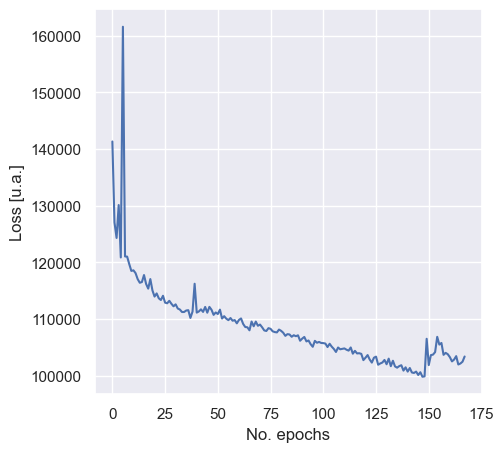

In [69]:
fig, ax = plt.subplots(1, 1, figsize=[5, 5])
plt.plot(history.history['loss'], label='train')
ax.set_xlabel("No. epochs")
ax.set_ylabel("Loss [u.a.]")

In [70]:
X_test_scale = X_scaler.transform(X_test)
y_predict = np.exp(-model.predict(X_test_scale))
#y_predict = model.predict(X_test_scale)
y_predict_train = np.exp(-model.predict(X_train_scale))
#y_predict_train = model.predict(X_train_scale)
#y_predict_death = model.predict(X_test_scale)[1]>0.5

from lifelines.utils import concordance_index

#print(concordance_index_ipcw(y_train,y_test,y_predict.flatten(),tau=365))
#print(concordance_index_ipcw(y_train,y_train,y_predict_train.flatten(),tau=365))

print(concordance_index(y_train_scale, y_predict_train, E_train))
print(concordance_index(y_test_scale, y_predict, y_test["death_in_study"]))

from sklearn.metrics import accuracy_score
#print(sum(y_predict_death))
#print(accuracy_score(y_test["death_observed"],y_predict_death))
#concordance_index_ipcw(y_train,y_test,Y_scaler.inverse_transform(y_predict).flatten(),tau=365)

404/404 [==============================] - 0s 769us/step
0.8738761600213263
0.6889816640792179


C:\Users\harri\AppData\Local\Temp\ipykernel_10884\3270086246.py:4: RuntimeWarning: overflow encountered in exp
  y_predict_train = np.exp(-model.predict(X_train_scale))


In [58]:
sum(y_predict<365)/len(y_predict)

array([0.99906977])

In [59]:
y_predict

array([[1.54977298e+00],
       [1.00842384e+02],
       [8.72703120e-02],
       ...,
       [3.51617336e-02],
       [8.53003383e-01],
       [2.17274451e+00]], dtype=float32)

In [60]:
print(min(y_predict))
#min(Y_scaler.inverse_transform(y_predict))
max(-np.log(y_predict))



[0.00877637]


array([4.735692], dtype=float32)

In [61]:
print(max(y_predict))
min(-np.log(y_predict))
#max(Y_scaler.inverse_transform(y_predict))


[2.4751084e+11]


array([-26.23472], dtype=float32)

In [33]:
max(model.predict(X_train_scale)[0])

404/404 [==============================] - 0s 743us/step


-3.9367585

404/404 [==============================] - 0s 735us/step


<Axes: ylabel='Density'>

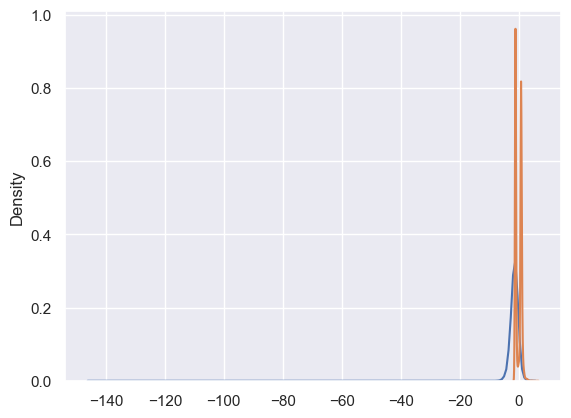

In [36]:
sns.kdeplot(x=model.predict(X_train_scale)[:,0])
sns.kdeplot(x=y_train_scale)

404/404 [==============================] - 0s 869us/step


C:\Users\harri\AppData\Local\Temp\ipykernel_10884\2213868592.py:1: RuntimeWarning: overflow encountered in exp
  sns.kdeplot(x=np.clip(np.exp(-model.predict(X_train_scale)[:,0]),a_max=2,a_min=-2))


<Axes: ylabel='Density'>

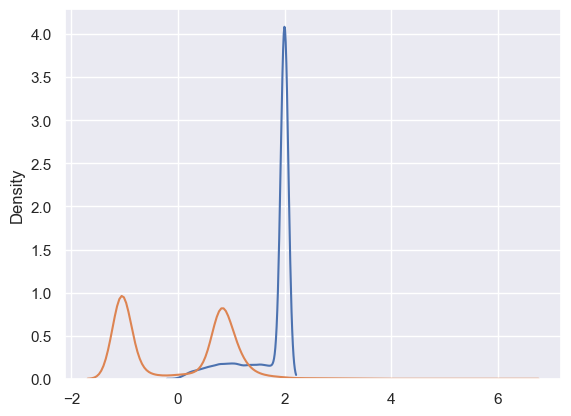

In [38]:
sns.kdeplot(x=np.clip(np.exp(-model.predict(X_train_scale)[:,0]),a_max=2,a_min=0))
sns.kdeplot(x=y_train_scale)

101/101 [==============================] - 0s 787us/step


<Axes: ylabel='Density'>

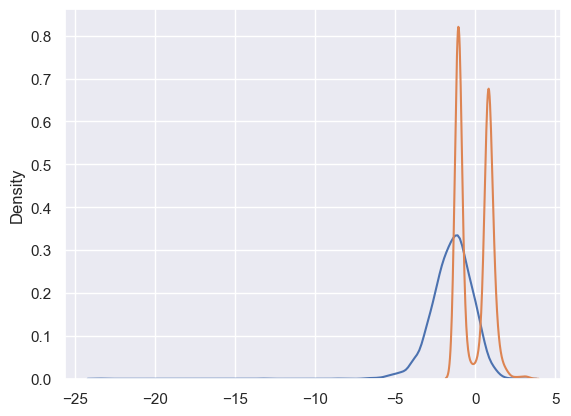

In [39]:
#sns.kdeplot(x=y_test_scale)
sns.kdeplot(x=model.predict(X_test_scale)[:,0])
sns.kdeplot(x=y_test_scale)

<Axes: ylabel='Density'>

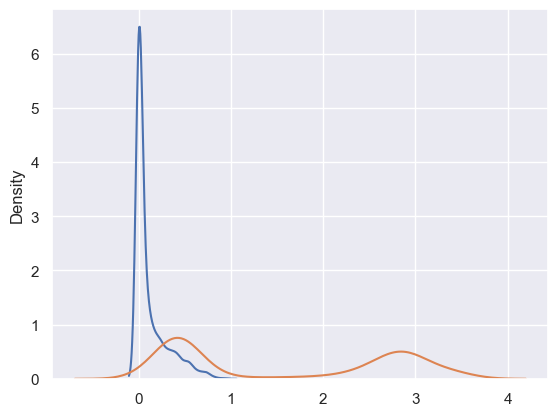

In [40]:
sns.kdeplot(x=np.exp(-y_predict)[:,0])
sns.kdeplot(x=np.exp(-y_test_scale))

In [41]:
Y_scaler.inverse_transform(y_predict)[:,0]

array([ 1773.9669 , 16011.453  ,   485.11703, ...,   412.91113,
         312.66382, 10299.357  ], dtype=float32)

In [ ]:
from deepsurvk.datasets import load_whas

In [ ]:
X_train, Y_train, E_train, = load_whas(partition='training', data_type='np')
X_test, Y_test, E_test = load_whas(partition='testing', data_type='np')

In [ ]:
sns.kdeplot(x=np.exp(-y_test_scale))

In [ ]:
sns.kdeplot(x=y_train["event_max"])

In [ ]:
X_scaler = StandardScaler().fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

Y_scaler = StandardScaler().fit(Y_train.reshape(-1, 1))
Y_train = Y_scaler.transform(Y_train)
Y_test = Y_scaler.transform(Y_test)

In [ ]:
Y_test

In [ ]:
Y_scaler.mean_

In [ ]:
y_predict.reshape((-1,1))